In [1]:
%matplotlib inline

In [40]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
def download_data(ticker, start, end, interval='1m'):
    """ 
    The function downloads market data to a pandas DataFrame 
    using the 'yfinance' API between the dates specified.
    """    
    return yf.download(ticker, start, end, interval=interval)

In [4]:
ticker = "^NSEI"

In [5]:
start, end = datetime.date(2011, 5, 1), datetime.date(2021, 4, 30)

In [6]:
data = download_data(ticker, start, end, '1d')

[*********************100%***********************]  1 of 1 completed


In [7]:
data.shape

(2442, 6)

In [8]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-05-02,5766.899902,5775.250000,5687.700195,5701.299805,5701.299805,0
2011-05-03,5689.700195,5710.799805,5554.850098,5565.250000,5565.250000,0
2011-05-04,5567.700195,5578.799805,5503.000000,5537.149902,5537.149902,0
2011-05-05,5531.600098,5560.299805,5443.649902,5459.850098,5459.850098,0
2011-05-06,5477.649902,5564.399902,5472.450195,5551.450195,5551.450195,0
...,...,...,...,...,...,...
2021-04-23,14326.349609,14461.150391,14273.299805,14341.349609,14341.349609,498100
2021-04-26,14449.450195,14557.500000,14421.299805,14485.000000,14485.000000,452700
2021-04-27,14493.799805,14667.549805,14484.849609,14653.049805,14653.049805,451800


In [75]:
def calc_returns(data, shift=1, plot=True):
    """Calculates returns of a strategy
    @params:
    data = pandas dataframe with c2c_rets & daily_rets column and signal (1 for long, -1 for short & 0 for neutral) columns
           data['daily_rets'] should have returns calculated as per strategy entry-exit rule
    shift = Number of days signal should be shifted to calculate strategy returns. 
            e.g., Use shift=1 if trade entered same day as signal
                  Use shift=2 if trade entered next day from signal
    plot = True if plotting required
    @returns:
    returns = calculated returns of strategy
    """
    data['bnh_returns'] = (1 + data.c2c_rets).cumprod() # buy and hold returns
    data['strat_returns'] = (1 + data.daily_rets * data.signal.shift(shift)).cumprod() # strategy returns
    
    if plot:
        plotcols = ['signal', 'bnh_returns', 'strat_returns']
        results[plotcols].plot(secondary_y=['signal'], figsize=(20, 10))
    
    return data['bnh_returns'][-1], data['strat_returns'][-1]

## Strategy I
I. Backtests a strategy using three moving averages on any indices such as Nifty50, SPY,
HSI and so on.
1. Compute three moving averages of 20, 40, and 80.
2. Go long when the price crosses above all three moving averages.
3. Exit the long position when the price crosses below any of the three moving
averages.
4. Go short when the price crosses below all three moving averages.
5. Exit the short position when the price crosses above any of the three moving
averages.
6. Optional: Optimise all three moving averages

In [9]:
def backtest_3ma_crossover(data, malist, plot=True):
    """Backtests moving average crossover strategy described above
    @params:
    data = pandas dataframe with daily prices indexed by date
    malist = [ma1, ma2, ma3] => list of 3 moving average windows for backtesting
    plot = True if plotting required
    @returns:
    results = dataframe with close to close returns, daily returns, moving averages, signal
    """
    # Create dataframe to store values
    results = data[['Close']].copy()
    
    results['ma1'] = results['Close'].rolling(window=malist[0]).mean()    # moving average 1 of close price
    results['ma2'] = results['Close'].rolling(window=malist[1]).mean()    # moving average 2 of close price
    results['ma3'] = results['Close'].rolling(window=malist[2]).mean()    # moving average 3 of close price
    
    results['c2c_rets'] = results['Close'].pct_change()                   # daily returns of close price
    results['daily_rets'] = results['Close'].pct_change()                 # daily returns for strategy
    
    # Long signal
    results['signal'] = np.where(
        (results.Close > results.ma1) &
        (results.Close > results.ma2) &
        (results.Close > results.ma3), 1, 0)
    
    # Long exit signal
    long_exit = (results.Close < results.ma1) | \
                (results.Close < results.ma2) | \
                (results.Close < results.ma3)
    results['signal'] = np.where(
        long_exit & 
        (results.signal.shift(1) == 1), 0, results.signal)
    
    # Short signal
    results['signal'] = np.where(
        (results.Close < results.ma1) &
        (results.Close < results.ma2) &
        (results.Close < results.ma3), -1, results.signal)
    
    # Short exit signal
    short_exit = (results.Close > results.ma1) | \
                 (results.Close > results.ma2) | \
                 (results.Close > results.ma3)
    results['signal'] = np.where(
        short_exit & 
        (results.signal.shift(1) == -1), 0, results.signal)
    
    if plot:
        plotcols = ['Close', 'ma1', 'ma2', 'ma3', 'signal']
        results[plotcols].plot(secondary_y=['signal'], figsize=(20, 10))
        
    return results    

,Close,ma1,ma2,ma3,daily_rets,signal
Date,,,,,,
2011-05-02,5701.299805,NaN,NaN,NaN,NaN,0
2011-05-03,5565.250000,NaN,NaN,NaN,-0.023863,0
2011-05-04,5537.149902,NaN,NaN,NaN,-0.005049,0
2011-05-05,5459.850098,NaN,NaN,NaN,-0.013960,0
2011-05-06,5551.450195,NaN,NaN,NaN,0.016777,0
...,...,...,...,...,...,...
2021-04-23,14341.349609,14593.337451,14741.592456,14620.024353,-0.004498,-1
2021-04-26,14485.000000,14576.849951,14736.824951,14631.073108,0.010017,-1
2021-04-27,14653.049805,14582.032422,14735.456201,14642.370605,0.011602,0


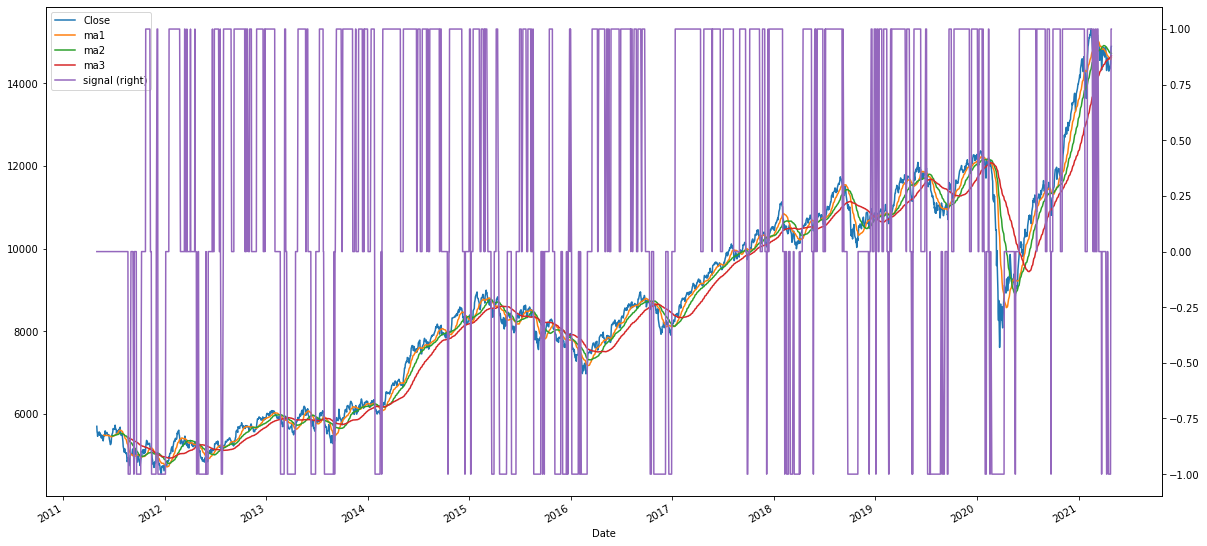

In [47]:
malist = [20, 40, 80]
results = backtest_3ma_crossover(data, malist)
results

<AxesSubplot:xlabel='Date'>

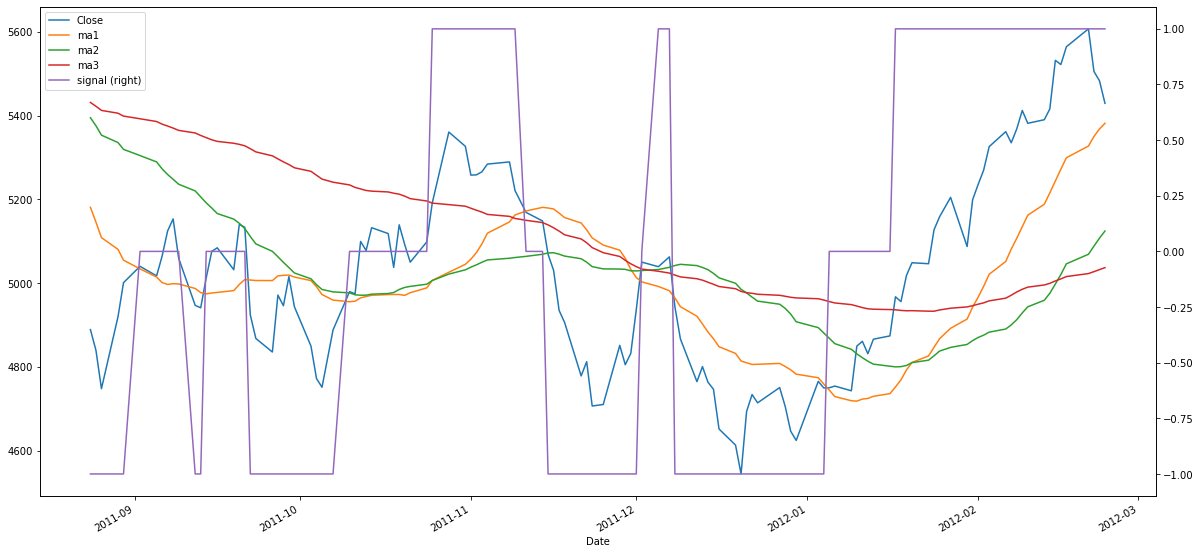

In [12]:
plotcols = ['Close', 'ma1', 'ma2', 'ma3', 'signal']
results.iloc[80:200][plotcols].plot(secondary_y=['signal'], figsize=(20, 10))

(2.612544665407468, 1.8638633962221112)

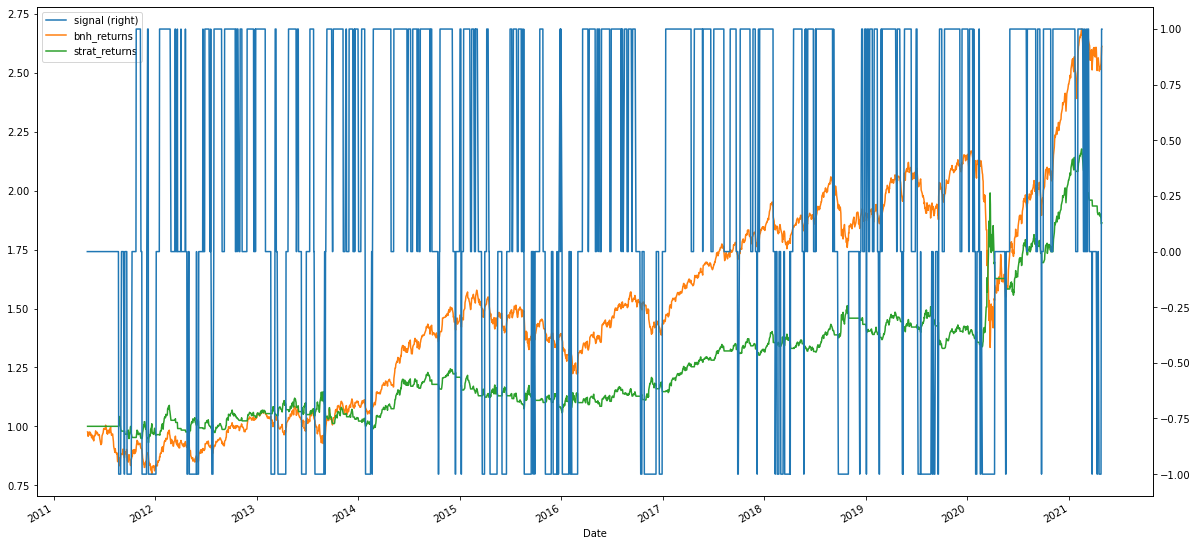

In [13]:
bnh_rets, strat_rets = calc_returns(results)
bnh_rets, strat_rets

In [14]:
print(f'Buy & Hold returns: {bnh_rets}, Strategy returns: {strat_rets}')

Buy & Hold returns: 2.612544665407468, Strategy returns: 1.8638633962221112


In [15]:
def optimise_3ma_crossover(data, ma1list, ma2list, ma3list):
    df = pd.DataFrame(columns=['ma1', 'ma2', 'ma3', 'strat_rets'])
    for ma1 in ma1list:
        for ma2 in ma2list:
            for ma3 in ma3list:
                results = backtest_3ma_crossover(data, [ma1, ma2, ma3], plot=False)
                rets = calc_returns(results, plot=False)
                print(f'ma1: {ma1}, ma2: {ma2}, ma3: {ma3}, strat_rets: {rets[1]}')
                df.loc[df.shape[0]] = [ma1, ma2, ma3, rets[1]]
                
    return df.loc[df['strat_rets'].idxmax()]

In [17]:
ma1list = [5, 10, 15, 20, 30]
ma2list = [35, 40, 50, 60, 70]
ma3list = [80, 90, 100, 120, 150]

best_param = optimise_3ma_crossover(data, ma1list, ma2list, ma3list)

ma1: 5, ma2: 35, ma3: 80, strat_rets: 1.4915015436186514
ma1: 5, ma2: 35, ma3: 90, strat_rets: 1.303562647722273
ma1: 5, ma2: 35, ma3: 100, strat_rets: 1.345389390370452
ma1: 5, ma2: 35, ma3: 120, strat_rets: 1.4290291914494988
ma1: 5, ma2: 35, ma3: 150, strat_rets: 1.3390126241922469
ma1: 5, ma2: 40, ma3: 80, strat_rets: 1.4988625501273034
ma1: 5, ma2: 40, ma3: 90, strat_rets: 1.3144298818798432
ma1: 5, ma2: 40, ma3: 100, strat_rets: 1.356605315868025
ma1: 5, ma2: 40, ma3: 120, strat_rets: 1.414934944477046
ma1: 5, ma2: 40, ma3: 150, strat_rets: 1.3263650662724278
ma1: 5, ma2: 50, ma3: 80, strat_rets: 1.3774406441534899
ma1: 5, ma2: 50, ma3: 90, strat_rets: 1.2464276226423934
ma1: 5, ma2: 50, ma3: 100, strat_rets: 1.2717273790547592
ma1: 5, ma2: 50, ma3: 120, strat_rets: 1.3079035004665416
ma1: 5, ma2: 50, ma3: 150, strat_rets: 1.2476539636099668
ma1: 5, ma2: 60, ma3: 80, strat_rets: 1.369970835177202
ma1: 5, ma2: 60, ma3: 90, strat_rets: 1.2218623146059688
ma1: 5, ma2: 60, ma3: 100, 

In [19]:
print('!!! Best parameters !!!')
print(f'MA1: {best_param.ma1}, MA2: {best_param.ma2}, MA3: {best_param.ma3}, Strategy Returns: {best_param.strat_rets}')

!!! Best parameters !!!
MA1: 30.0, MA2: 40.0, MA3: 80.0, Strategy Returns: 1.9837925448837361


## Strategy II
II. Buy and sell the next day
1. Buy the stock on the fourth day open, if the stock closes down consecutively for
three days.
2. Exit on the next day open.
3. Optional: Optimise the strategy by exiting the long position on the same day close.
Also, you can optimise the number of down days. There are high chances that the
number of down days would be different for each stock.

In [56]:
def backtest_buy_after_subsequent_downs(data, downdays, sellmode='next_open', plot=True):
    """Backtests moving average crossover strategy described above
    @params:
    data = pandas dataframe with daily prices indexed by date
    downdays = number of downdays to generate buy signal
    sellmode = 'next_open' or 'sameday_close' => when to exit long position
    plot = True if plotting required
    @returns:
    results = dataframe with daily returns, moving averages, signal
    """
    assert sellmode in ('next_open', 'sameday_close'), "Sellmode must be either 'next_open' or 'sameday_close'"
    assert isinstance(downdays, int) and downdays > 0, "Downdays must be a positive integer"
    
    # Create dataframe to store values
    results = data[['Open', 'Close']].copy()
    
    # daily returns of close price
    results['c2c_rets'] = results['Close'].pct_change()                 
    # daily returns based on strategy sellmode
    results['daily_rets'] = results['Open'].pct_change() if sellmode == 'next_open' \
                                                            else (results['Close'] - results['Open']) / results['Open']
    # Long signal
    results['signal'] =  1
    for i in range(downdays):
        results['signal'] = np.where(
            results['signal'] &
            (results['Close'].shift(i-1) < results['Close'].shift(i)), 1, 0
        )
    
    if plot:
        plotcols = ['Close', 'signal']
        results[plotcols].plot(secondary_y=['signal'], figsize=(20, 10))
        
    return results    

In [100]:
def optimise_buy_after_subsequent_downs(data, sellmodes, downdays):
    df = pd.DataFrame(columns=['sellmode', 'downdays', 'strat_rets'])
    for mode in sellmodes:
        for dd in downdays:
            results = backtest_buy_after_subsequent_downs(data, downdays=dd, sellmode=mode, plot=False)
            rets = calc_returns(results, plot=False)
            print(f'Sellmode: {mode}, Downdays: {dd}, strat_rets: {rets[1]}')
            df.loc[df.shape[0]] = [mode, dd, rets[1]]
                
    return df.loc[df['strat_rets'].idxmax()]

In [93]:
downdays = 3
sellmode = 'next_open'
results = backtest_buy_after_subsequent_downs(data, downdays=downdays, sellmode=sellmode, plot=False)

In [94]:
results.head(15)

,Open,Close,c2c_rets,daily_rets,signal
Date,,,,,
2011-05-02,5766.899902,5701.299805,NaN,NaN,0
2011-05-03,5689.700195,5565.250000,-0.023863,-0.013387,0
2011-05-04,5567.700195,5537.149902,-0.005049,-0.021442,1
2011-05-05,5531.600098,5459.850098,-0.013960,-0.006484,0
2011-05-06,5477.649902,5551.450195,0.016777,-0.009753,0
2011-05-09,5575.200195,5551.100098,-0.000063,0.017809,0
2011-05-10,5555.549805,5541.250000,-0.001774,-0.003525,0
2011-05-11,5547.200195,5565.049805,0.004295,-0.001503,0
2011-05-12,5537.799805,5486.149902,-0.014178,-0.001695,0


Buy & Hold returns: 2.612544665407468, Strategy returns: 0.1492250615723831


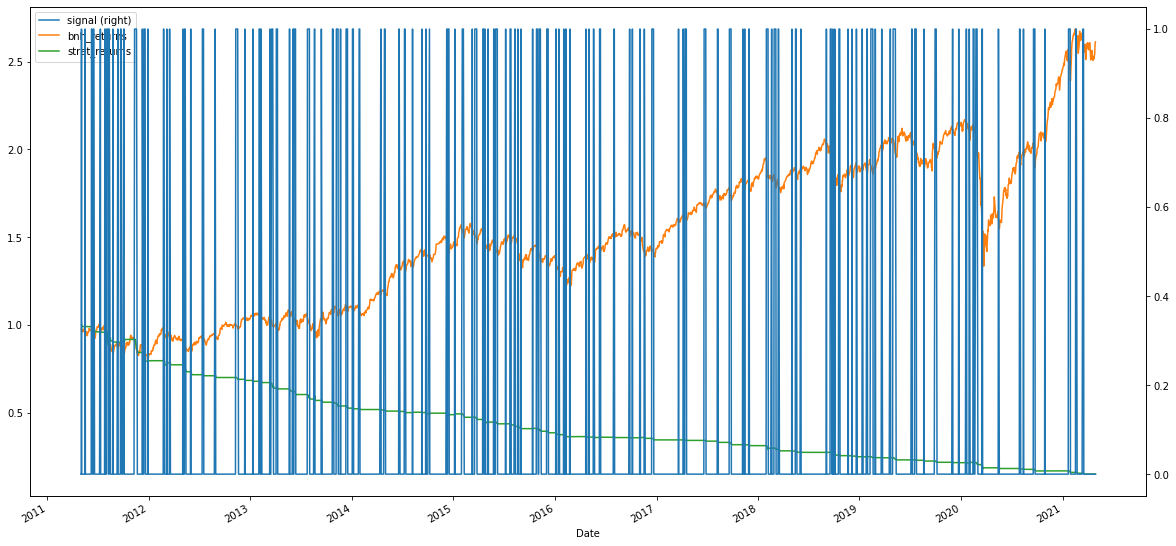

In [95]:
bnh_rets, strat_rets = calc_returns(results, shift=2)
print(f'Buy & Hold returns: {bnh_rets}, Strategy returns: {strat_rets}')

In [96]:
results.head(50)

,Open,Close,c2c_rets,daily_rets,signal,bnh_returns,strat_returns
Date,,,,,,,
2011-05-02,5766.899902,5701.299805,NaN,NaN,0,NaN,NaN
2011-05-03,5689.700195,5565.250000,-0.023863,-0.013387,0,0.976137,NaN
2011-05-04,5567.700195,5537.149902,-0.005049,-0.021442,1,0.971208,1.000000
2011-05-05,5531.600098,5459.850098,-0.013960,-0.006484,0,0.957650,1.000000
2011-05-06,5477.649902,5551.450195,0.016777,-0.009753,0,0.973717,0.990247
2011-05-09,5575.200195,5551.100098,-0.000063,0.017809,0,0.973655,0.990247
2011-05-10,5555.549805,5541.250000,-0.001774,-0.003525,0,0.971927,0.990247
2011-05-11,5547.200195,5565.049805,0.004295,-0.001503,0,0.976102,0.990247
2011-05-12,5537.799805,5486.149902,-0.014178,-0.001695,0,0.962263,0.990247


<AxesSubplot:xlabel='Date'>

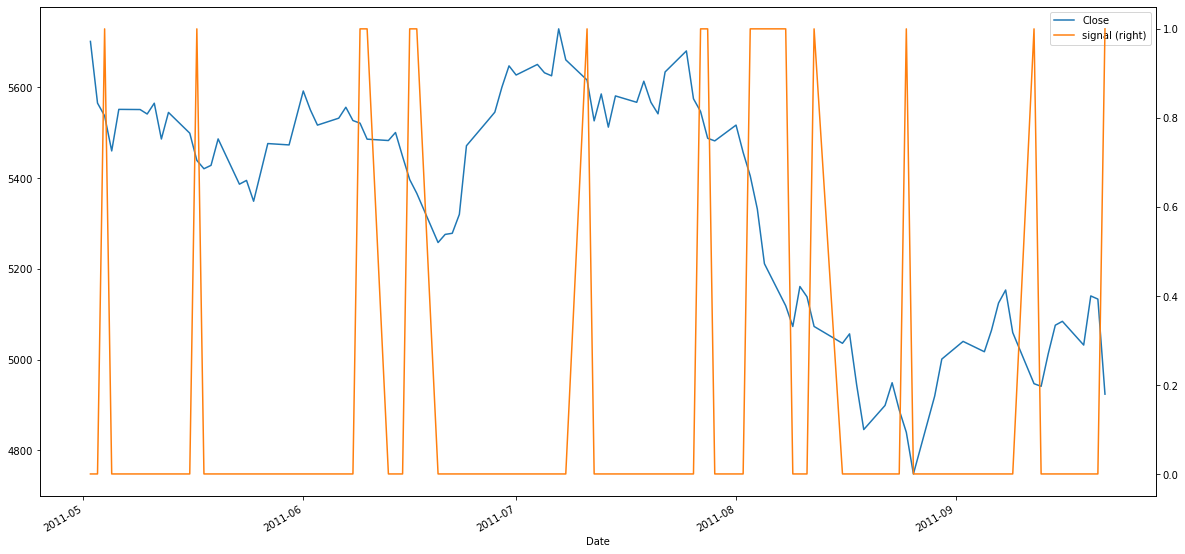

In [65]:
plotcols = ['Close', 'signal']
results.iloc[:100][plotcols].plot(secondary_y=['signal'], figsize=(20, 10))

In [103]:
sellmodes = ['next_open', 'sameday_close']
downdays = [2, 3, 4, 5, 6, 7, 8, 9]
best_param = optimise_buy_after_subsequent_downs(data, sellmodes=sellmodes, downdays=downdays)

Sellmode: next_open, Downdays: 2, strat_rets: 0.011569145213330525
Sellmode: next_open, Downdays: 3, strat_rets: 0.10842178063364209
Sellmode: next_open, Downdays: 4, strat_rets: 0.2883901781369737
Sellmode: next_open, Downdays: 5, strat_rets: 0.5400393111628142
Sellmode: next_open, Downdays: 6, strat_rets: 0.718236393164873
Sellmode: next_open, Downdays: 7, strat_rets: 0.9209249766557801
Sellmode: next_open, Downdays: 8, strat_rets: 0.9754583782815256
Sellmode: next_open, Downdays: 9, strat_rets: 0.9950990402815888
Sellmode: sameday_close, Downdays: 2, strat_rets: 0.018020395669550052
Sellmode: sameday_close, Downdays: 3, strat_rets: 0.1150311882699976
Sellmode: sameday_close, Downdays: 4, strat_rets: 0.333562208625394
Sellmode: sameday_close, Downdays: 5, strat_rets: 0.5632449712783537
Sellmode: sameday_close, Downdays: 6, strat_rets: 0.7466626648644317
Sellmode: sameday_close, Downdays: 7, strat_rets: 0.8492350530982274
Sellmode: sameday_close, Downdays: 8, strat_rets: 0.94941100633

In [104]:
print('!!! Best parameters !!!')
print(f'Sellmode: {best_param.sellmode}, Downdays: {best_param.downdays}, Strategy Returns: {best_param.strat_rets}')

!!! Best parameters !!!
Sellmode: next_open, Downdays: 9, Strategy Returns: 0.9950990402815888


## Strategy III
III. Strategy based on RSI indicator.
1. Buy the instrument such as Nifty or SPY when the RSI is less than 15
2. Exit conditions:
a. Take profit of 5% or RSI > 75
b. Stop loss of - 2%
© Copyright QuantInsti Quantitative Learning Private Limited. Page 2
3. Optional: Optimise the strategy by adjusting the RSI value. Also, take profit and stop
loss criteria can be different for each stock.
4. Note: You can use TA-Lib in Python to compute the RSI value.